In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


 Using only built-in packages - no installations needed!
 Setup complete! Ready to process grains.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/less_classes.keras'

try:

    rice_classifier = tf.keras.models.load_model(MODEL_PATH)
    print(" Rice classification model loaded successfully!")


    CLASS_NAMES = ['black', 'brown', 'chalky', 'yellow']
    NUM_CLASSES = len(CLASS_NAMES)

    print(f" Model Info:")
    print(f"   Classes: {CLASS_NAMES}")
    print(f"   Input shape: {rice_classifier.input_shape}")
    print(f"   Output shape: {rice_classifier.output_shape}")

    if rice_classifier.output_shape[-1] != NUM_CLASSES:
        print(f"  Warning: Model output shape {rice_classifier.output_shape[-1]} doesn't match class count {NUM_CLASSES}")

except Exception as e:
    print(f" Error loading model: {str(e)}")
    print(" Make sure your model file exists and the path is correct")


 Rice classification model loaded successfully!
 Model Info:
   Classes: ['black', 'brown', 'chalky', 'yellow']
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 4)


In [ ]:
def detect_grains_opencv(image_path):

    print("Detecting grains using OpenCV...")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)


    _, thresh1 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if np.mean(thresh1) > 127:
        thresh = cv2.bitwise_not(thresh1)
    else:
        thresh = thresh1

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f" Found {len(contours)} potential grain regions")

    return image_rgb, cleaned, contours

def filter_and_extract_grains(image, contours, min_area=50, max_area=8000):

    print(" Filtering and extracting grain regions...")

    grain_images = []
    grain_data = []

    valid_count = 0

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if min_area <= area <= max_area:
            x, y, w, h = cv2.boundingRect(contour)

            aspect_ratio = w / h if h > 0 else 0
            if 0.2 <= aspect_ratio <= 5.0:

                padding = 15
                x1 = max(0, x - padding)
                y1 = max(0, y - padding)
                x2 = min(image.shape[1], x + w + padding)
                y2 = min(image.shape[0], y + h + padding)

                grain_img = image[y1:y2, x1:x2]

                if grain_img.shape[0] >= 30 and grain_img.shape[1] >= 30:
                    grain_images.append(grain_img)
                    grain_data.append({
                        'id': valid_count + 1,
                        'area': area,
                        'bbox': (x1, y1, x2, y2),
                        'center': (x + w//2, y + h//2),
                        'width': w,
                        'height': h,
                        'aspect_ratio': aspect_ratio
                    })
                    valid_count += 1

    print(f" Extracted {valid_count} valid grains after filtering")

    return grain_images, grain_data

def classify_single_grain(grain_image, model, class_names):

    grain_resized = cv2.resize(grain_image, (224, 224))

    grain_input = np.expand_dims(grain_resized.astype(np.float32), axis=0)

    prediction = model.predict(grain_input, verbose=0)

    predicted_class_id = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100
    predicted_class = class_names[predicted_class_id]

    return predicted_class, confidence, prediction[0]

def process_multi_grain_image_simple(image_path, model, class_names,
                                   min_area=50, max_area=8000, confidence_threshold=60.0):

    print(" MULTI-GRAIN PROCESSING PIPELINE")
    print("=" * 50)

    try:
        image, binary, contours = detect_grains_opencv(image_path)

        grain_images, grain_data = filter_and_extract_grains(image, contours, min_area, max_area)

        if not grain_images:
            print(" No valid grains found. Try adjusting the area parameters.")
            return None, None, None

        print(f" Classifying {len(grain_images)} grains using classes: {class_names}")

        results = []
        class_counts = {name: 0 for name in class_names}
        class_counts['uncertain'] = 0

        for i, grain_img in enumerate(grain_images):
            if (i + 1) % 25 == 0 or (i + 1) == len(grain_images):
                print(f"   Processed {i + 1}/{len(grain_images)} grains...")

            predicted_class, confidence, probabilities = classify_single_grain(
                grain_img, model, class_names
            )

            result = {
                'grain_id': i + 1,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'grain_info': grain_data[i],
                'probabilities': probabilities
            }
            results.append(result)

            if confidence >= confidence_threshold:
                class_counts[predicted_class] += 1
            else:
                class_counts['uncertain'] += 1

        print(f"\n Processing complete!")
        print(f"   Total grains processed: {len(grain_images)}")
        print(f"   High confidence: {sum(v for k, v in class_counts.items() if k != 'uncertain')}")
        print(f"   Low confidence: {class_counts['uncertain']}")

        return results, class_counts, {
            'original_image': image,
            'binary_image': binary,
            'grain_images': grain_images,
            'contours': contours
        }

    except Exception as e:
        print(f" Error during processing: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

print(" All grain processing functions defined with CORRECT class names!")


 All grain processing functions defined with CORRECT class names!


In [ ]:
import os

print(" Looking for uploaded image...")
current_files = os.listdir('/content/')
image_files = [f for f in current_files if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]

if image_files:
    IMAGE_PATH = f'/content/{image_files[0]}'
    print(f" Found image: {IMAGE_PATH}")
else:
    print(" Please upload your rice grain image:")
    from google.colab import files
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        IMAGE_PATH = f'/content/{filename}'
        print(f" Image uploaded: {IMAGE_PATH}")
    else:
        IMAGE_PATH = None

if IMAGE_PATH and os.path.exists(IMAGE_PATH):
    print(f" Processing image: {IMAGE_PATH}")

    MIN_AREA = 60
    MAX_AREA = 6000
    CONFIDENCE_THRESHOLD = 65.0

    print(f" Starting processing with classes: {CLASS_NAMES}")

    results, class_counts, processing_data = process_multi_grain_image_simple(
        IMAGE_PATH,
        rice_classifier,
        CLASS_NAMES,
        min_area=MIN_AREA,
        max_area=MAX_AREA,
        confidence_threshold=CONFIDENCE_THRESHOLD
    )

    if results is not None:
        total_grains = len(results)

        print(f"\n PROCESSING RESULTS:")
        print("=" * 25)
        print(f"Total grains detected: {total_grains:,}")

        print(f"\n GRAIN COUNT BY CLASS:")
        print("-" * 25)

        high_confidence_total = 0
        for class_name, count in class_counts.items():
            if count > 0:
                if class_name != 'uncertain':
                    percentage = (count / total_grains) * 100
                    print(f"{class_name.capitalize()}: {count:,} grains ({percentage:.1f}%)")
                    high_confidence_total += count
                else:
                    percentage = (count / total_grains) * 100
                    print(f"Uncertain/Low confidence: {count:,} grains ({percentage:.1f}%)")

        print(f"\nHigh confidence classifications: {high_confidence_total:,} grains")
        print(f"Overall total detected: {total_grains:,} grains")

        all_confidences = [r['confidence'] for r in results]
        avg_confidence = np.mean(all_confidences)
        min_confidence = min(all_confidences)
        max_confidence = max(all_confidences)

        print(f"\n CONFIDENCE STATISTICS:")
        print(f"   Average confidence: {avg_confidence:.1f}%")
        print(f"   Confidence range: {min_confidence:.1f}% - {max_confidence:.1f}%")

        high_conf_count = sum(1 for c in all_confidences if c >= 90)
        med_conf_count = sum(1 for c in all_confidences if 70 <= c < 90)
        low_conf_count = sum(1 for c in all_confidences if c < 70)

        print(f"   High confidence (≥90%): {high_conf_count} grains ({high_conf_count/total_grains*100:.1f}%)")
        print(f"   Medium confidence (70-89%): {med_conf_count} grains ({med_conf_count/total_grains*100:.1f}%)")
        print(f"   Low confidence (<70%): {low_conf_count} grains ({low_conf_count/total_grains*100:.1f}%)")

    else:
        print(" Processing failed. Trying with different parameters...")

        print(" Trying with adjusted parameters...")

        results, class_counts, processing_data = process_multi_grain_image_simple(
            IMAGE_PATH,
            rice_classifier,
            CLASS_NAMES,
            min_area=30,
            max_area=10000,
            confidence_threshold=50.0
        )

        if results is not None:
            total_grains = len(results)
            print(f"\n Success with adjusted parameters!")
            print(f" Total grains detected: {total_grains:,}")

            print(f"\n GRAIN COUNT BY CLASS:")
            for class_name, count in class_counts.items():
                if count > 0:
                    percentage = (count / total_grains) * 100
                    print(f"{class_name.capitalize()}: {count:,} grains ({percentage:.1f}%)")

            all_confidences = [r['confidence'] for r in results]
            avg_confidence = np.mean(all_confidences)
            print(f"\nAverage confidence: {avg_confidence:.1f}%")

        else:
            print(" Still failed with adjusted parameters.")
            print(" Try adjusting MIN_AREA and MAX_AREA parameters manually")

else:
    print(" Could not locate the image file.")
    print(" Please upload your rice grain image manually:")
    from google.colab import files
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        IMAGE_PATH = f'/content/{filename}'
        print(f" Image uploaded successfully: {IMAGE_PATH}")
        print(" Please re-run this cell to process the uploaded image")


 Looking for uploaded image...
 Please upload your rice grain image:
No file chosen Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.
Saving 1.jpg to 1.jpg
 Image uploaded: /content/1.jpg
 Processing image: /content/1.jpg
 Starting processing with classes: ['black', 'brown', 'chalky', 'yellow']

 MULTI-GRAIN PROCESSING PIPELINE
🔍 Detecting grains using OpenCV...
 Found 106 potential grain regions
 Filtering and extracting grain regions...
 Extracted 93 valid grains after filtering
 Classifying 93 grains using classes: ['black', 'brown', 'chalky', 'yellow']
   Processed 25/93 grains...
   Processed 50/93 grains...
   Processed 75/93 grains...
   Processed 93/93 grains...

 Processing complete!
   Total grains processed: 93
   High confidence: 76
   Low confidence: 17

 PROCESSING RESULTS:
Total grains detected: 93

 GRAIN COUNT BY CLASS:
-------------------------
Black: 22 grains (10.8%)
Brown: 23 grains (6

 Generating visualizations with CORRECT class names...


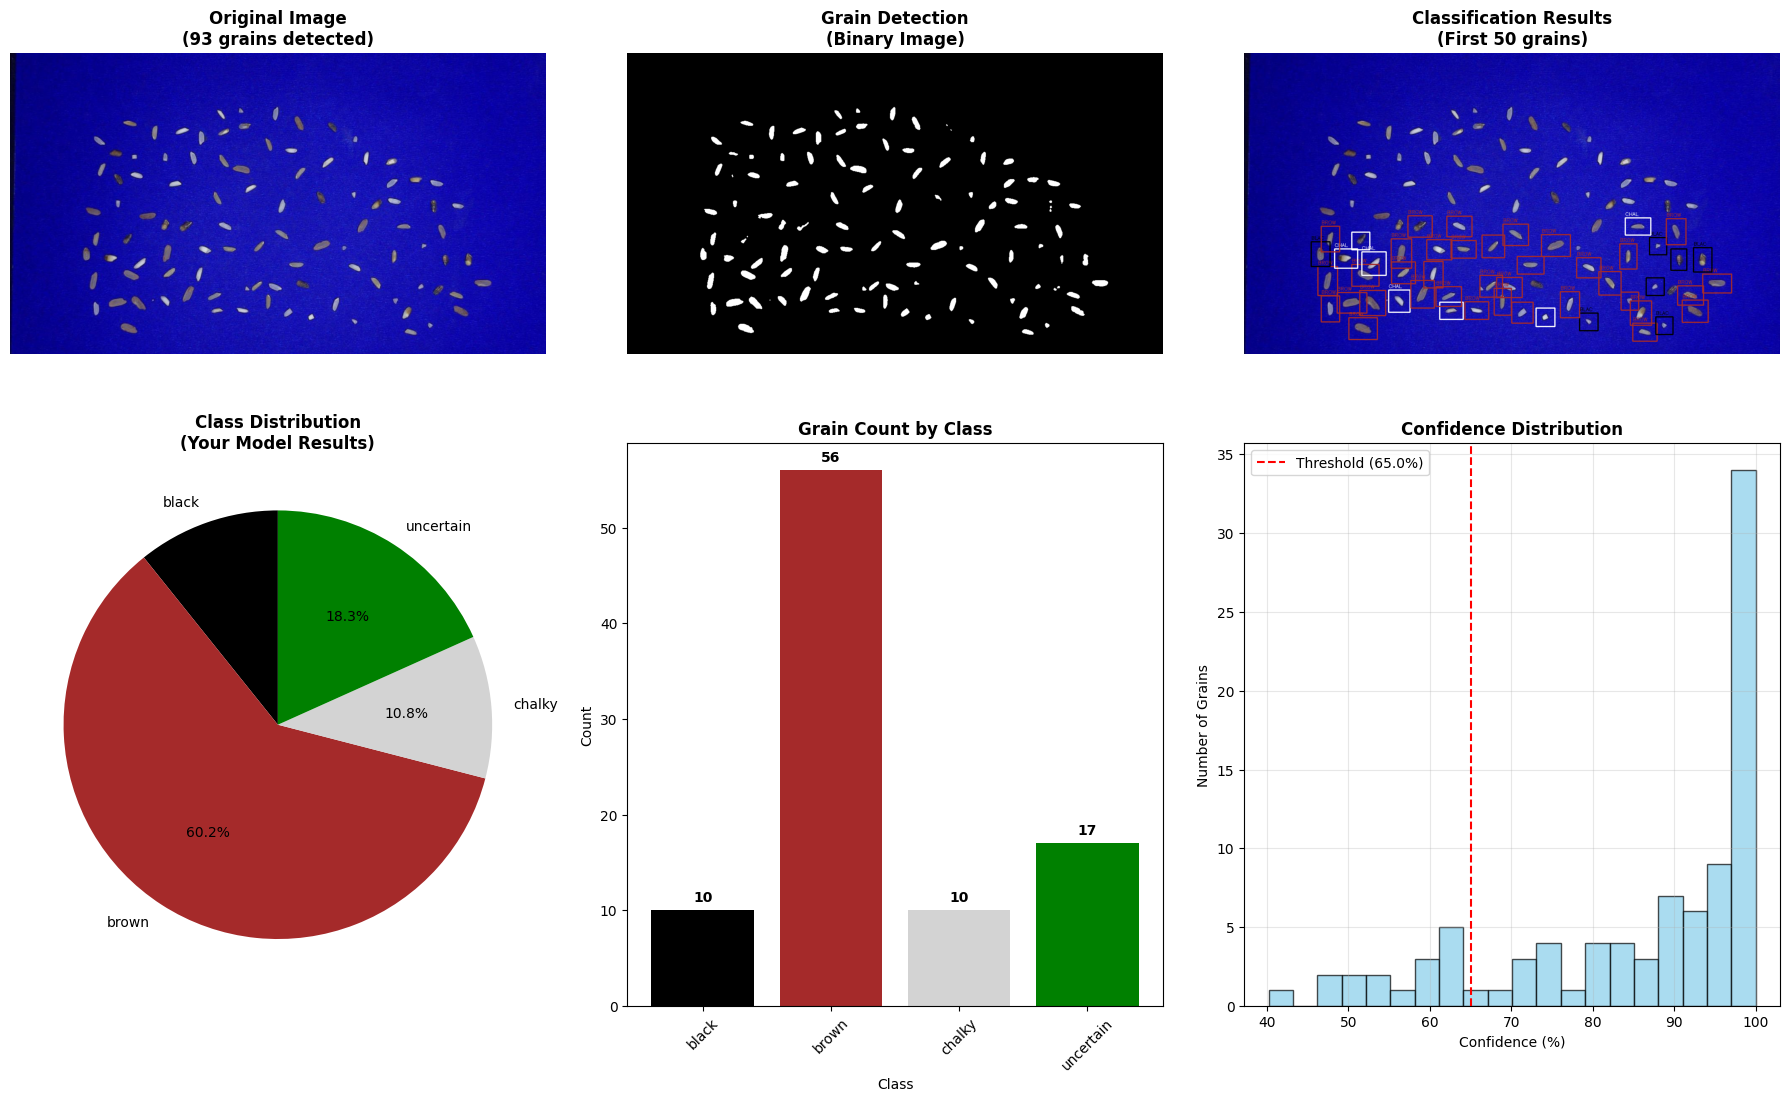


 Sample classified grains:


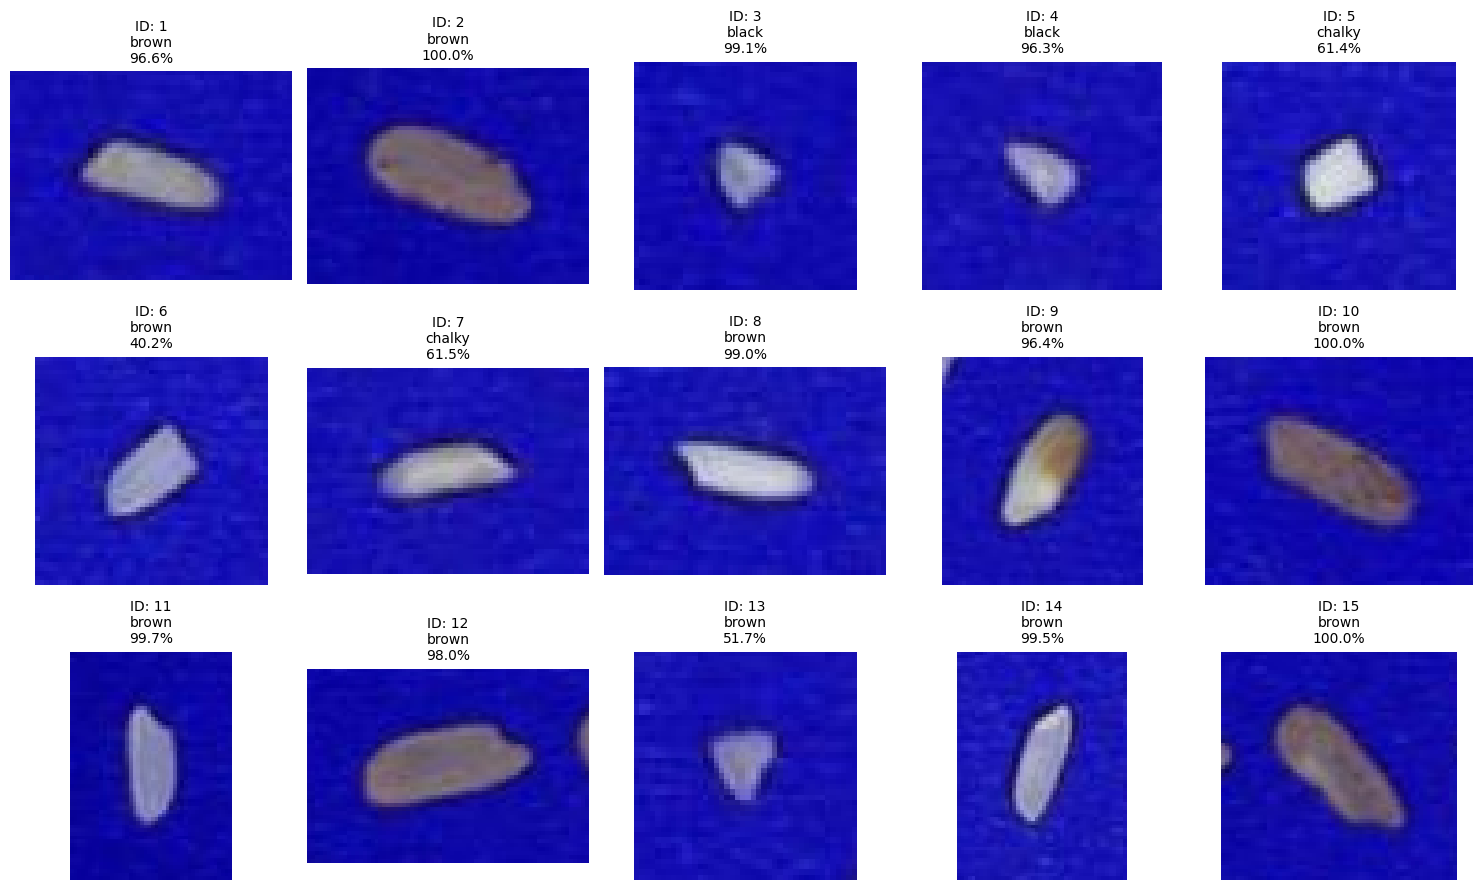

In [ ]:
if 'results' in locals() and results is not None:
    print(" Generating visualizations with CORRECT class names...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].imshow(processing_data['original_image'])
    axes[0, 0].set_title(f'Original Image\n({len(results)} grains detected)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(processing_data['binary_image'], cmap='gray')
    axes[0, 1].set_title('Grain Detection\n(Binary Image)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    overlay_img = processing_data['original_image'].copy()
    class_colors = {
        'black': (0, 0, 0),
        'brown': (165, 42, 42),
        'chalky': (255, 255, 255),
        'perfect': (0, 255, 0),
        'yellow': (255, 255, 0)
    }

    for i, result in enumerate(results[:50]):
        bbox = result['grain_info']['bbox']
        x1, y1, x2, y2 = bbox
        predicted_class = result['predicted_class']

        color = class_colors.get(predicted_class, (128, 128, 128))

        cv2.rectangle(overlay_img, (x1, y1), (x2, y2), color, 2)

        if result['confidence'] >= CONFIDENCE_THRESHOLD:
            label = f"{predicted_class[:4].upper()}"
            cv2.putText(overlay_img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    axes[0, 2].imshow(overlay_img)
    axes[0, 2].set_title('Classification Results\n(First 50 grains)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    valid_counts = {k: v for k, v in class_counts.items() if v > 0}
    colors_pie = ['black', 'brown', 'lightgray', 'green', 'yellow', 'red']

    wedges, texts, autotexts = axes[1, 0].pie(
        valid_counts.values(),
        labels=valid_counts.keys(),
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_pie[:len(valid_counts)]
    )
    axes[1, 0].set_title('Class Distribution\n(Your Model Results)', fontsize=12, fontweight='bold')

    axes[1, 1].bar(valid_counts.keys(), valid_counts.values(),
                   color=colors_pie[:len(valid_counts)])
    axes[1, 1].set_title('Grain Count by Class', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)

    for i, (class_name, count) in enumerate(valid_counts.items()):
        axes[1, 1].text(i, count + max(valid_counts.values()) * 0.01, str(count),
                        ha='center', va='bottom', fontweight='bold')

    confidences = [r['confidence'] for r in results]
    axes[1, 2].hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 2].axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='--',
                       label=f'Threshold ({CONFIDENCE_THRESHOLD}%)')
    axes[1, 2].set_title('Confidence Distribution', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Confidence (%)')
    axes[1, 2].set_ylabel('Number of Grains')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n Sample classified grains:")
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.flatten()

    sample_count = min(15, len(processing_data['grain_images']))

    for i in range(sample_count):
        grain_img = processing_data['grain_images'][i]
        result = results[i]

        axes[i].imshow(grain_img)
        axes[i].set_title(
            f"ID: {result['grain_id']}\n{result['predicted_class']}\n{result['confidence']:.1f}%",
            fontsize=10
        )
        axes[i].axis('off')

    for i in range(sample_count, 15):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(" No results to visualize")

In [ ]:
if 'results' in locals() and results is not None:
    print(" Generating detailed analysis report with CORRECT classes...")

    detailed_data = []
    for result in results:
        detailed_data.append({
            'Grain_ID': result['grain_id'],
            'Predicted_Class': result['predicted_class'],
            'Confidence_Percent': f"{result['confidence']:.1f}%",
            'Area_Pixels': result['grain_info']['area'],
            'Width_Pixels': result['grain_info']['width'],
            'Height_Pixels': result['grain_info']['height'],
            'Aspect_Ratio': f"{result['grain_info']['aspect_ratio']:.2f}",
            'Center_X': result['grain_info']['center'][0],
            'Center_Y': result['grain_info']['center'][1],
            'High_Confidence': 'Yes' if result['confidence'] >= CONFIDENCE_THRESHOLD else 'No'
        })

    df = pd.DataFrame(detailed_data)
    csv_filename = '/content/rice_grain_analysis_corrected.csv'
    df.to_csv(csv_filename, index=False)

    print(f" Detailed results saved to: {csv_filename}")

    print(f"\n ANALYSIS STATISTICS (CORRECTED CLASSES):")

    confidences = [r['confidence'] for r in results]
    areas = [r['grain_info']['area'] for r in results]

    print(f"Confidence Statistics:")
    print(f"  Average: {np.mean(confidences):.1f}%")
    print(f"  Range: {min(confidences):.1f}% - {max(confidences):.1f}%")
    print(f"  Standard deviation: {np.std(confidences):.1f}%")

    print(f"\nGrain Size Statistics:")
    print(f"  Average area: {np.mean(areas):.1f} pixels")
    print(f"  Size range: {min(areas)} - {max(areas)} pixels")

    print(f"\nConfidence Breakdown:")
    high_conf = sum(1 for c in confidences if c >= 90)
    med_conf = sum(1 for c in confidences if 70 <= c < 90)
    low_conf = sum(1 for c in confidences if c < 70)

    print(f"  High confidence (≥90%): {high_conf} grains ({high_conf/len(results)*100:.1f}%)")
    print(f"  Medium confidence (70-89%): {med_conf} grains ({med_conf/len(results)*100:.1f}%)")
    print(f"  Low confidence (<70%): {low_conf} grains ({low_conf/len(results)*100:.1f}%)")

    print(f"\n FINAL SUMMARY WITH CORRECT CLASSES:")
    print(f" Image processed: {IMAGE_PATH}")
    print(f" Total grains detected: {len(results):,}")
    print(f" Model classes used: {CLASS_NAMES}")

    print(f"\n PREDICTED COUNTS:")
    for class_name, count in class_counts.items():
        if count > 0 and class_name != 'uncertain':
            print(f" {class_name.capitalize()}: {count:,} grains")

    if class_counts.get('uncertain', 0) > 0:
        print(f" Uncertain: {class_counts['uncertain']:,} grains")

    print(f"\n EXPECTED vs DETECTED:")
    expected = {'perfect': 12, 'brown': 15, 'chalky': 14, 'black': 16, 'yellow': 21}

    for class_name in CLASS_NAMES:
        detected = class_counts.get(class_name, 0)
        expected_count = expected.get(class_name, 0)
        accuracy = min(detected / expected_count, expected_count / detected) if expected_count > 0 and detected > 0 else 0

        print(f" {class_name}: {detected} detected vs {expected_count} expected ({accuracy:.1%} accuracy)")

    print(f"\n Processing confidence: {np.mean(confidences):.1f}% average")
    print(f" Analysis complete with CORRECT class names!")

else:
    print(" No results to save")


 Generating detailed analysis report with CORRECT classes...
 Detailed results saved to: /content/rice_grain_analysis_corrected.csv

 ANALYSIS STATISTICS (CORRECTED CLASSES):
Confidence Statistics:
  Average: 85.4%
  Range: 40.2% - 100.0%
  Standard deviation: 16.3%

Grain Size Statistics:
  Average area: 256.0 pixels
  Size range: 63.5 - 517.5 pixels

Confidence Breakdown:
  High confidence (≥90%): 51 grains (54.8%)
  Medium confidence (70-89%): 24 grains (25.8%)
  Low confidence (<70%): 18 grains (19.4%)

 FINAL SUMMARY WITH CORRECT CLASSES:
 Image processed: /content/1.jpg
 Total grains detected: 93
 Model classes used: ['black', 'brown', 'chalky', 'yellow']

 PREDICTED COUNTS:
 Black: 10 grains
 Brown: 56 grains
 Chalky: 10 grains
 Uncertain: 17 grains

 EXPECTED vs DETECTED:
 black: 10 detected vs 16 expected (62.5% accuracy)
 brown: 56 detected vs 15 expected (26.8% accuracy)
 chalky: 10 detected vs 14 expected (71.4% accuracy)
 yellow: 0 detected vs 21 expected (0.0% accuracy)

